In [1]:
# Environment setup and module import
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


In [2]:
# Import DF from CSV

#train_file = 'data/train_clean.csv'
train_file = 'data/mini_train_clean.csv'
train_df = pd.read_csv(train_file, low_memory=False)


In [3]:
def reduce_mem(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train_df = reduce_mem(train_df)

Memory usage of dataframe is 43.58 MB
Memory usage after optimization is: 9.87 MB
Decreased by 77.4%


In [5]:
import gc
gc.collect()

20

In [6]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = [c for c,v in train_df.dtypes.items() if v in numerics and c in train_df.columns]
#numeric_cols

In [7]:
nominal_cols = [c for c in train_df.columns if (c not in numeric_cols)]
#nominal_cols

In [8]:
binary_cols = [c for c in train_df.columns if (train_df[c].nunique() == 2 and c not in nominal_cols)]
#binary_cols

In [9]:
#
# encode features with version numbers
#
def make_encoded_version_column(df, col):
    df[col] = df[col+'_major'] * 10000000 + df[col+'_minor'] * 100000 + df[col+'_build1'] * 1000 + df[col+'_build2']
    return df#.drop(columns=[col+'_major', col+'_minor',col+'_build1', col+'_build2'])

train_df = make_encoded_version_column(train_df, "EngineVersion")
train_df = make_encoded_version_column(train_df, "AppVersion")
train_df = make_encoded_version_column(train_df, "AvSigVersion")
train_df = make_encoded_version_column(train_df, "Census_OSVersion")

print("done encoding version columns")

done encoding version columns


In [10]:
#train_df['Census_OSVersion'].unique()
#train_df['AvSigVersion'].unique()
#train_df['EngineVersion'].unique()
train_df['AppVersion'].unique()


array([41790067, 41329332, 41789054, 40975080, 41185651, 41644868,
       40870274, 41329105, 41089720, 41180551, 41185662, 40869168,
       41012392, 40832768, 40833827, 41401855, 41427857, 40869757,
       41329216, 41329295, 40976693, 40870084, 40976146, 41090167,
       40833778, 41773994, 40870007, 40869840, 40810392, 40869662,
       41090875, 40976033, 40976673, 41401854, 40976874, 41184763,
       40870213, 40807392, 40976278, 40833738, 40977353, 40834273,
       40833586, 40521392, 40870130, 40833455, 40921392, 40870133,
       40376320, 40834298, 40833530, 40834330, 40833703, 41329423,
       40833497, 41008392, 40833568, 40577320, 40870041, 40977328,
       40708392, 40834302, 40834181, 41792055, 40833917, 40833993,
       40975806, 41090714, 40519392, 40834245, 41710362, 41791013])

IsBeta plot:


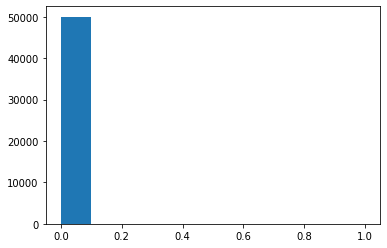

RtpStateBitfield plot:


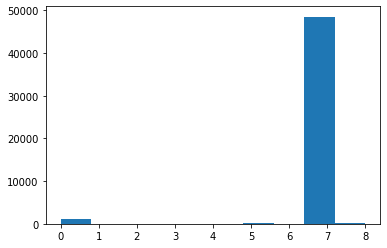

IsSxsPassiveMode plot:


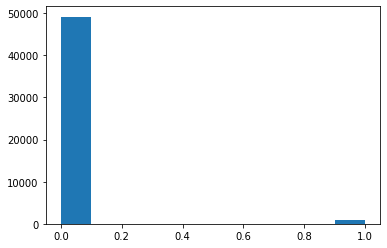

DefaultBrowsersIdentifier plot:


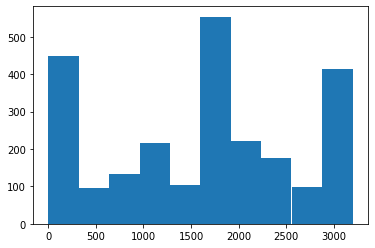

AVProductStatesIdentifier plot:


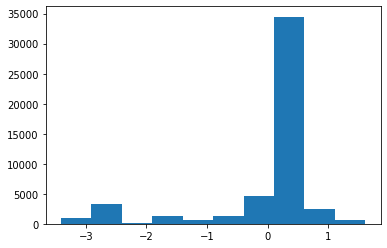

AVProductsInstalled plot:


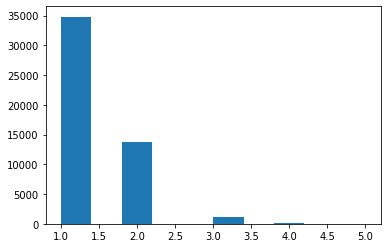

AVProductsEnabled plot:


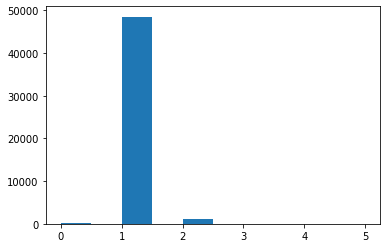

HasTpm plot:


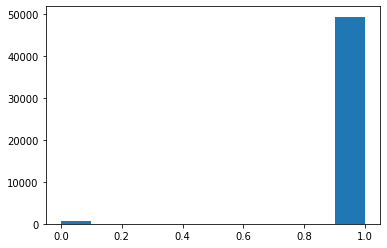

CountryIdentifier plot:


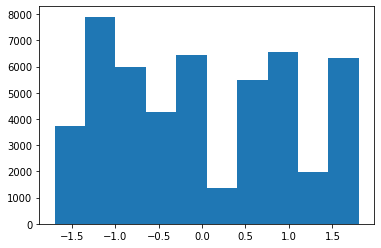

CityIdentifier plot:


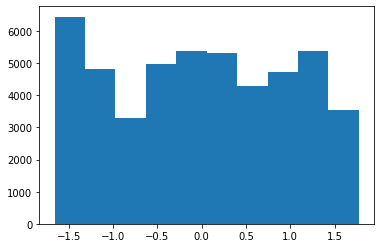

OrganizationIdentifier plot:


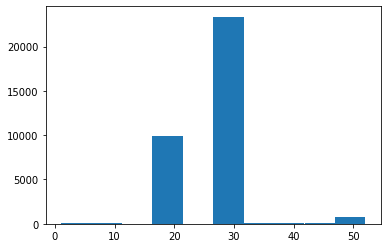

GeoNameIdentifier plot:


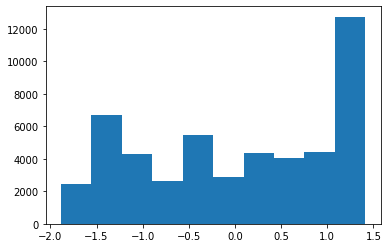

LocaleEnglishNameIdentifier plot:


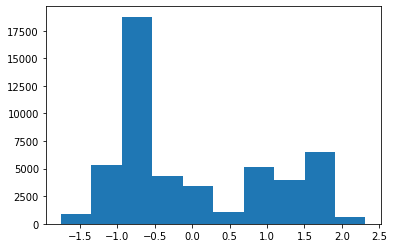

OsBuild plot:


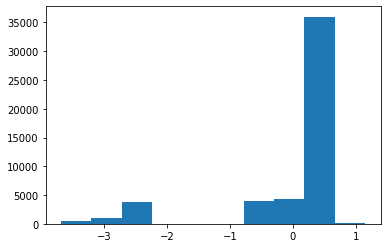

OsSuite plot:


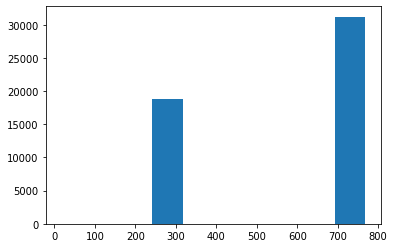

IsProtected plot:


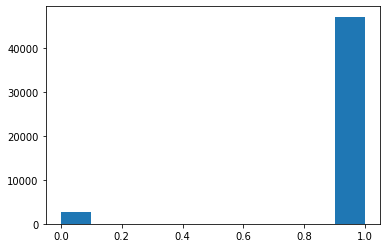

AutoSampleOptIn plot:


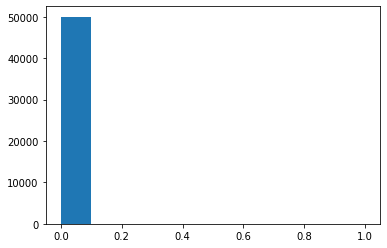

SMode plot:


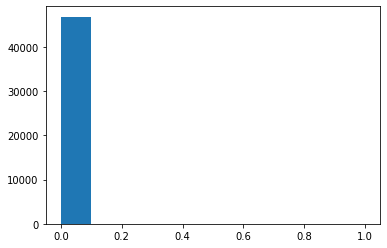

IeVerIdentifier plot:


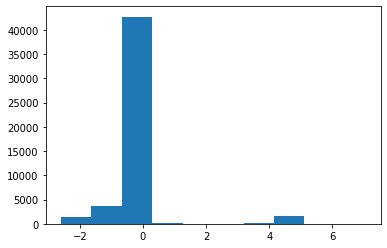

Firewall plot:


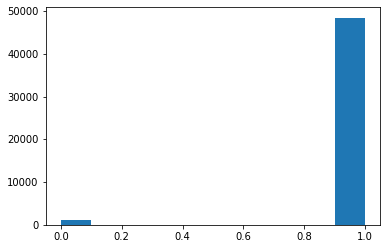

UacLuaenable plot:


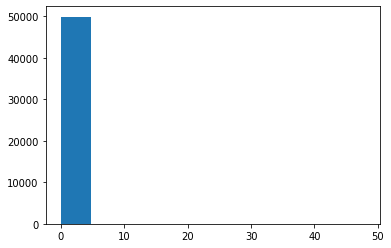

Census_OEMNameIdentifier plot:


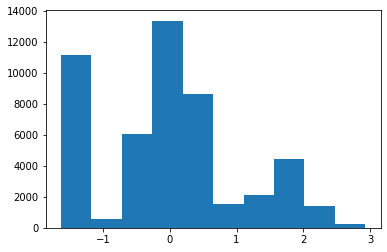

Census_OEMModelIdentifier plot:


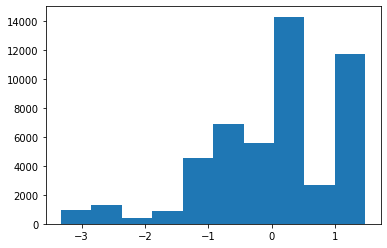

Census_ProcessorCoreCount plot:


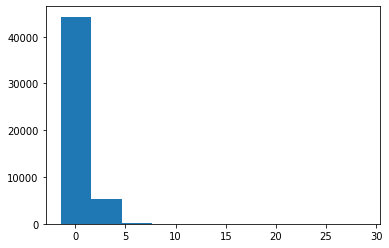

Census_ProcessorManufacturerIdentifier plot:


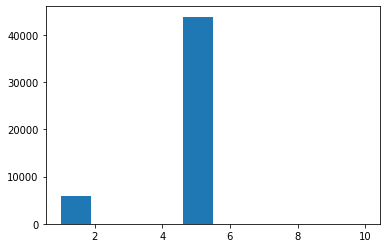

Census_ProcessorModelIdentifier plot:


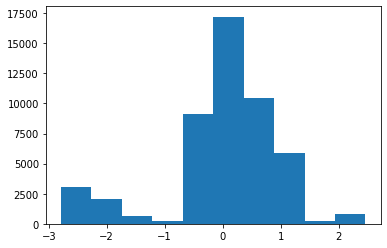

Census_PrimaryDiskTotalCapacity plot:


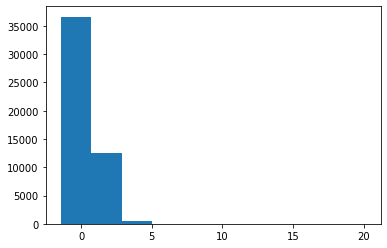

Census_SystemVolumeTotalCapacity plot:


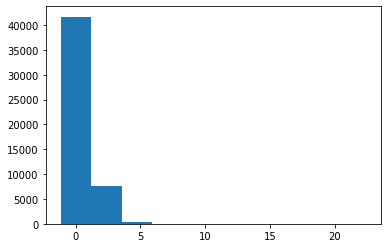

Census_HasOpticalDiskDrive plot:


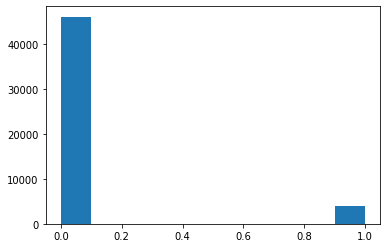

Census_TotalPhysicalRAM plot:


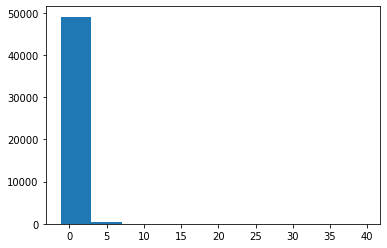

Census_InternalPrimaryDiagonalDisplaySizeInInches plot:


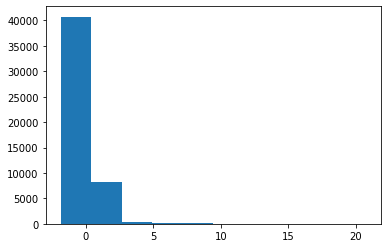

Census_InternalPrimaryDisplayResolutionHorizontal plot:


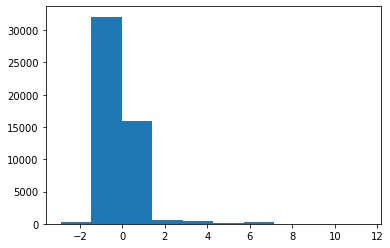

Census_InternalPrimaryDisplayResolutionVertical plot:


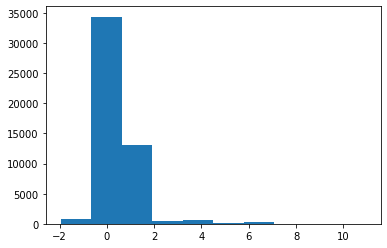

Census_InternalBatteryNumberOfCharges plot:


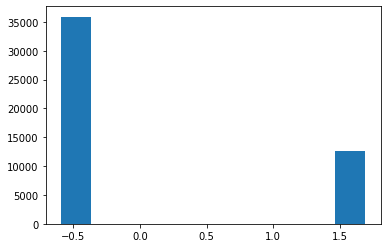

Census_OSBuildNumber plot:


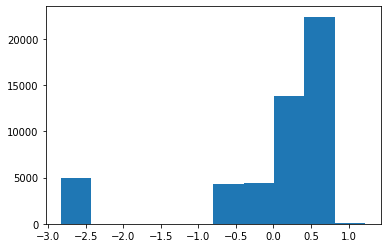

Census_OSBuildRevision plot:


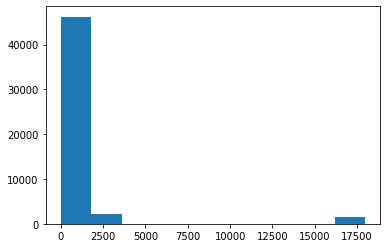

Census_OSInstallLanguageIdentifier plot:


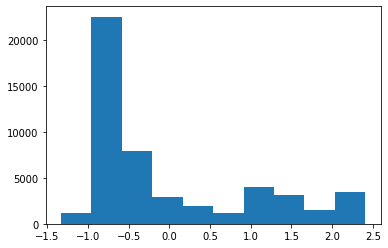

Census_OSUILocaleIdentifier plot:


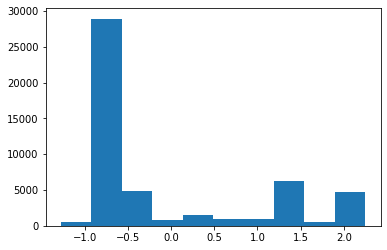

Census_IsPortableOperatingSystem plot:


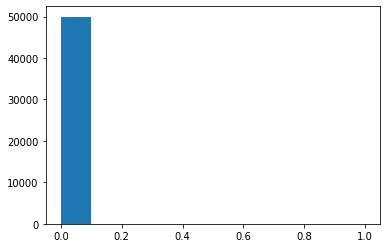

Census_IsFlightingInternal plot:


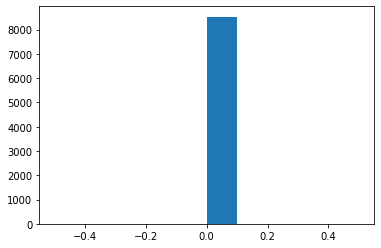

Census_IsFlightsDisabled plot:


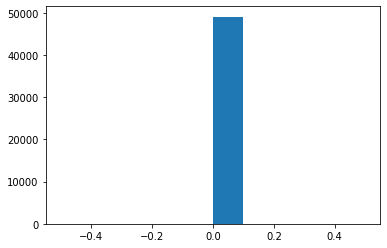

Census_ThresholdOptIn plot:


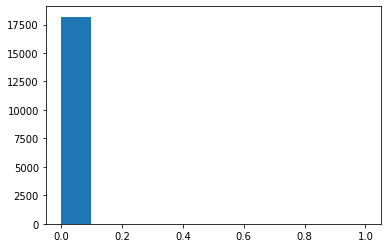

Census_FirmwareManufacturerIdentifier plot:


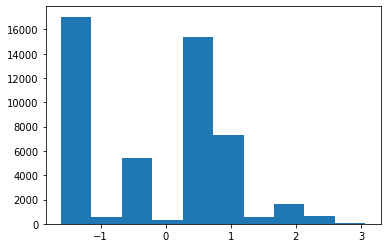

Census_FirmwareVersionIdentifier plot:


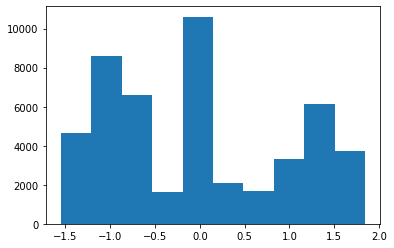

Census_IsSecureBootEnabled plot:


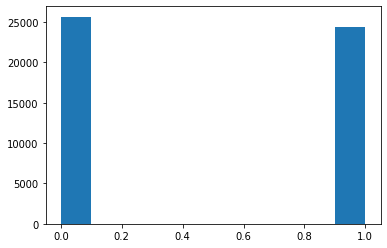

Census_IsWIMBootEnabled plot:


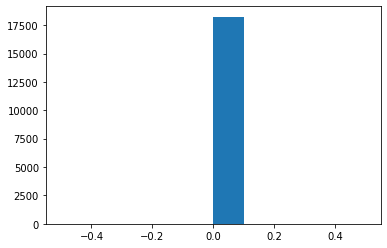

Census_IsVirtualDevice plot:


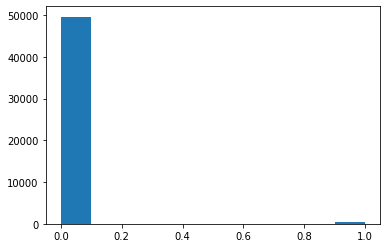

Census_IsTouchEnabled plot:


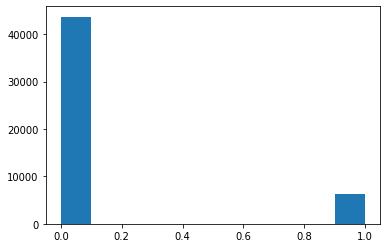

Census_IsPenCapable plot:


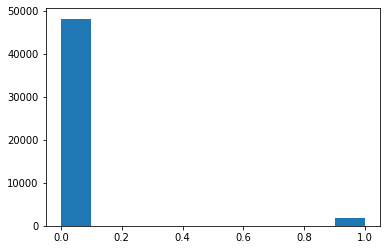

Census_IsAlwaysOnAlwaysConnectedCapable plot:


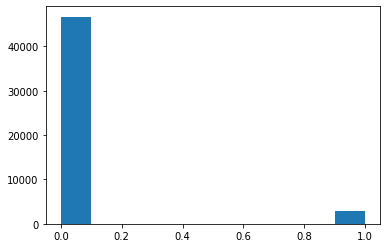

Wdft_IsGamer plot:


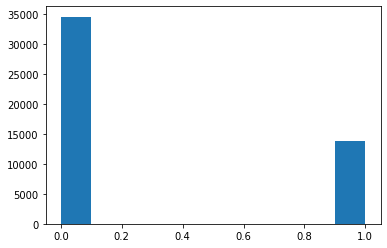

Wdft_RegionIdentifier plot:


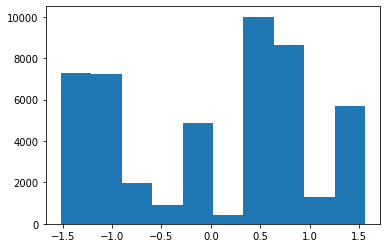

HasDetections plot:


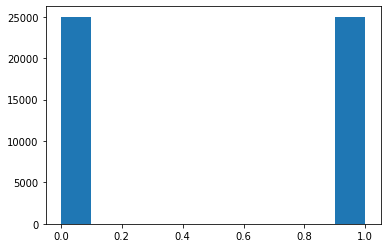

RtpStateBitfield_wasna plot:


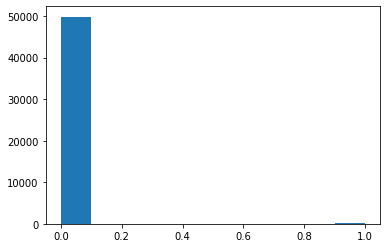

OsBuildLab_wasna plot:


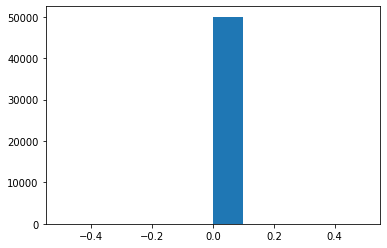

EngineVersion_major plot:


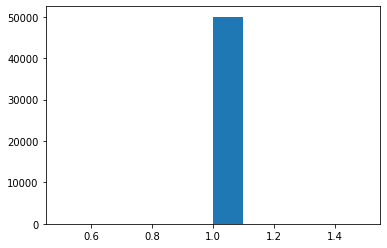

EngineVersion_minor plot:


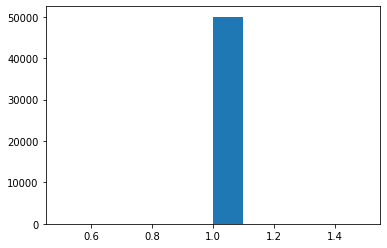

EngineVersion_build1 plot:


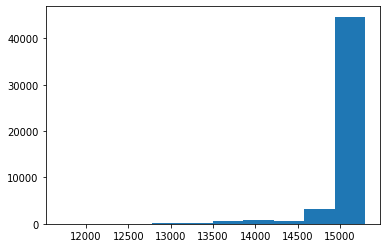

EngineVersion_build2 plot:


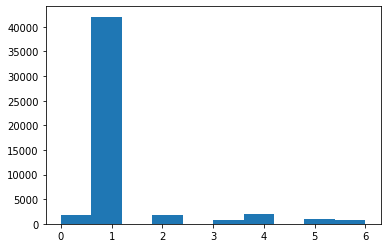

EngineVersion_combined plot:


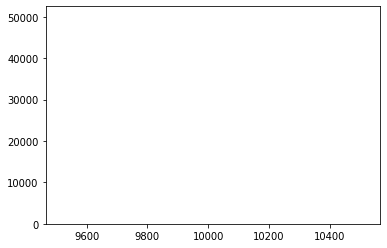

AppVersion_major plot:


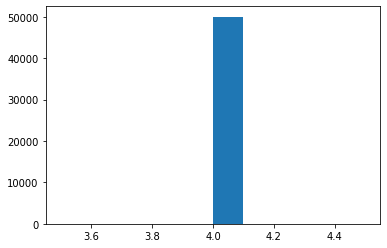

AppVersion_minor plot:


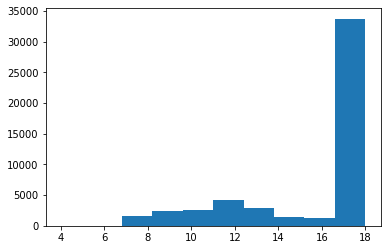

AppVersion_build1 plot:


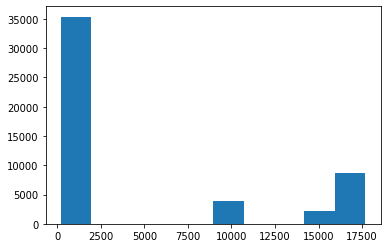

AppVersion_build2 plot:


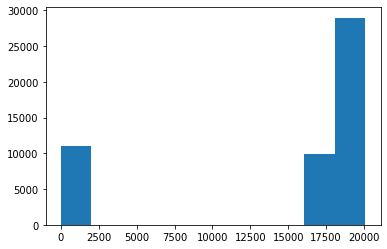

AppVersion_combined plot:


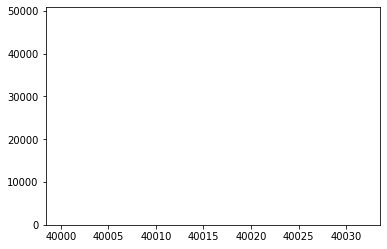

AvSigVersion_major plot:


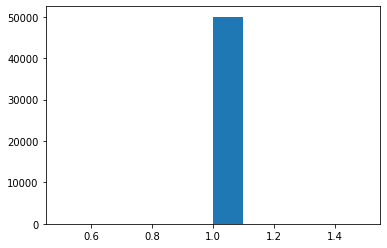

AvSigVersion_minor plot:


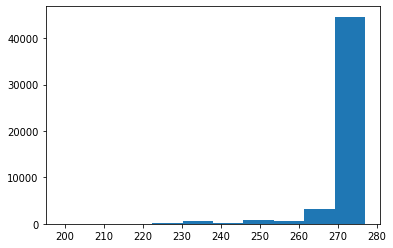

AvSigVersion_build1 plot:


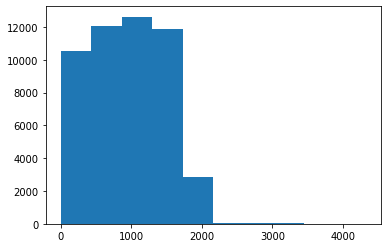

AvSigVersion_build2 plot:


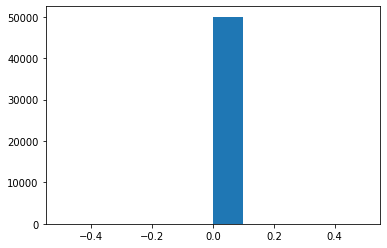

AvSigVersion_combined plot:


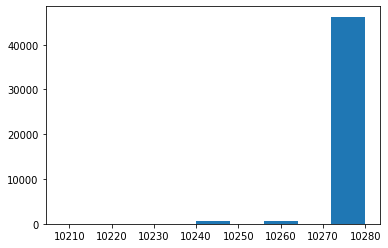

Census_OSVersion_major plot:


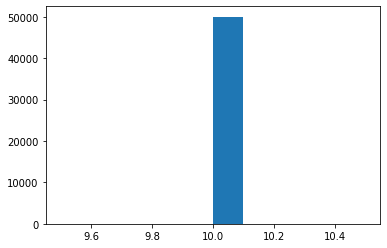

Census_OSVersion_minor plot:


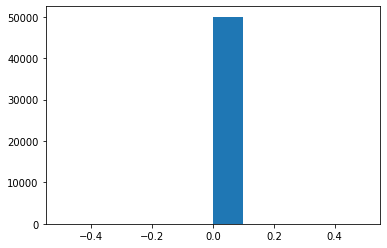

Census_OSVersion_build1 plot:


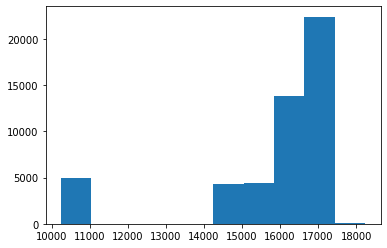

Census_OSVersion_build2 plot:


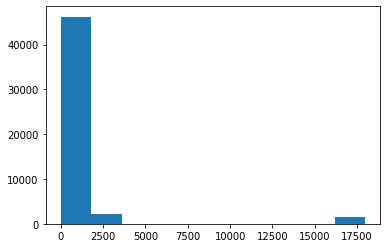

Census_OSVersion_combined plot:


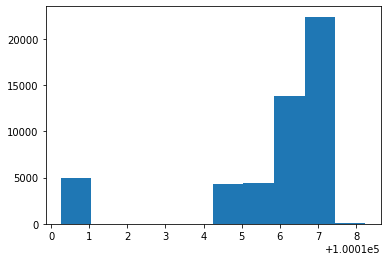

OsVer_major plot:


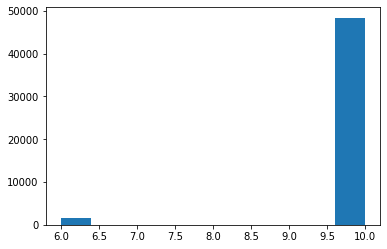

OsVer_minor plot:


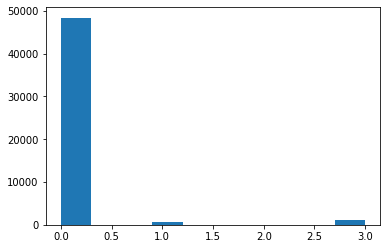

OsVer_build1 plot:


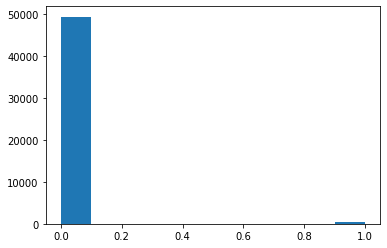

OsVer_build2 plot:


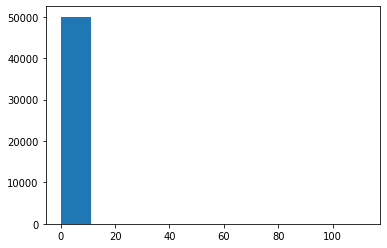

OsVer_combined plot:


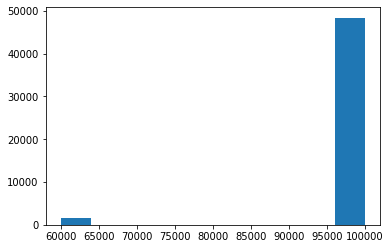

OsBuildLab_major plot:


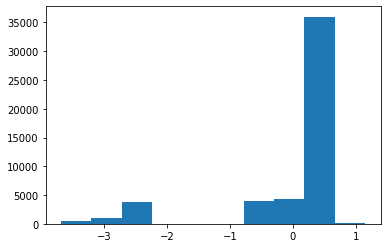

OsBuildLab_minor plot:


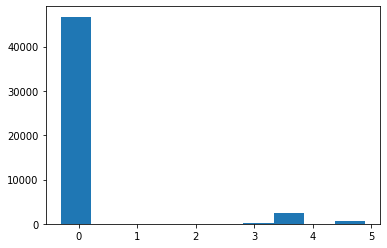

OsBuildLab_build1 plot:


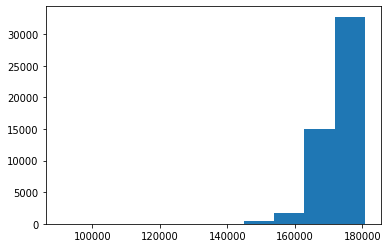

OsBuildLab_build2 plot:


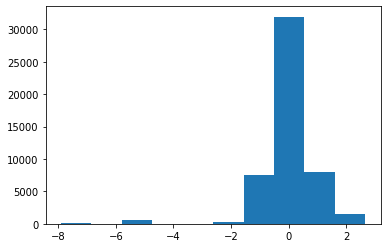

OsBuildLab_combined plot:


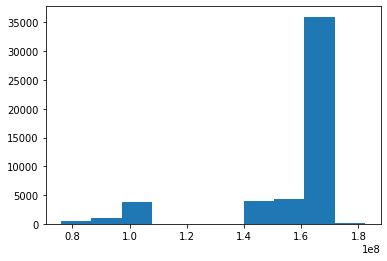

In [26]:
# Visualize the distributions

import matplotlib.pyplot as plt
%matplotlib inline
for n in numeric_cols:
    print(n,"plot:")
    plt.hist(train_df[n].dropna())
    plt.show()

In [12]:
# Encode nominal variables as labels
le = preprocessing.LabelEncoder()
#train_df = train_df[nominal_cols].apply(le.fit_transform)
# NOTE COME BACK TO THIS ANDREW:
nominal_cols.remove('PuaMode')
nominal_cols.remove('SmartScreen')
nominal_cols.remove('Census_ProcessorClass')
nominal_cols.remove('Census_PrimaryDiskTypeName')
nominal_cols.remove('Census_ChassisTypeName')
nominal_cols.remove('Census_InternalBatteryType')

for n in nominal_cols:
    train_df[n] = le.fit_transform(train_df[n])
# train_df[nominal_cols].head()

In [13]:
# split out labels and ids
#train_labels = train_df["HasDetections"].values
#train_ids = train_df["MachineIdentifier"].values
#train_df = train_df.drop(columns=["HasDetections", "MachineIdentifier"])
#for c in train_df.columns:
#    print(train_df[c])

In [14]:
# Perform whatever conversions are necessary to get everything into proper format: ndarray

le = preprocessing.LabelEncoder()
df = train_df[nominal_cols].apply(le.fit_transform)
for c in train_df.loc[:, train_df.dtypes == np.int8].columns:
    df[c] = train_df[c]
for c in train_df.loc[:, train_df.dtypes == np.int16].columns:
    df[c] = train_df[c]
for c in train_df.loc[:, train_df.dtypes == np.int32].columns:
    df[c] = train_df[c]
for c in train_df.loc[:, train_df.dtypes == np.float16].columns:
    df[c] = train_df[c]
for c in train_df[train_df.select_dtypes(bool).columns]:
    df[c] = train_df[c]


In [15]:
# Standardize and normalize

from sklearn.preprocessing import StandardScaler

# Declare what columns are planned here.
col_to_std = ['AVProductStatesIdentifier','CountryIdentifier','CityIdentifier','GeoNameIdentifier','LocaleEnglishNameIdentifier','OsBuild','IeVerIdentifier','Census_OEMNameIdentifier','Census_OEMModelIdentifier','Census_ProcessorCoreCount','Census_ProcessorModelIdentifier','Census_PrimaryDiskTotalCapacity','Census_SystemVolumeTotalCapacity','Census_TotalPhysicalRAM','Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal','Census_InternalPrimaryDisplayResolutionVertical','Census_InternalBatteryNumberOfCharges','Census_OSBuildNumber','Census_OSInstallLanguageIdentifier','Census_OSUILocaleIdentifier','Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Wdft_RegionIdentifier','OsBuildLab_major','OsBuildLab_minor','OsBuildLab_platform','OsBuildLab_release','OsBuildLab_build2']

scaled_features = train_df.copy()
features = scaled_features[col_to_std]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_to_std] = features
df = train_df = scaled_features

IsBeta plot:


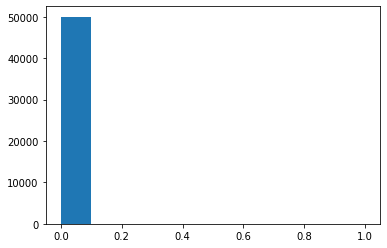

RtpStateBitfield plot:


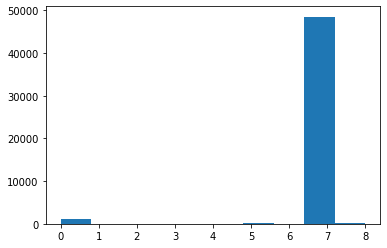

IsSxsPassiveMode plot:


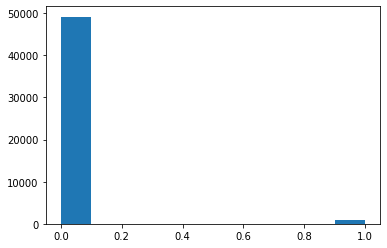

DefaultBrowsersIdentifier plot:


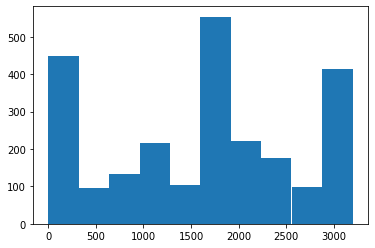

AVProductStatesIdentifier plot:


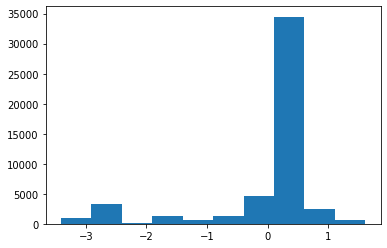

AVProductsInstalled plot:


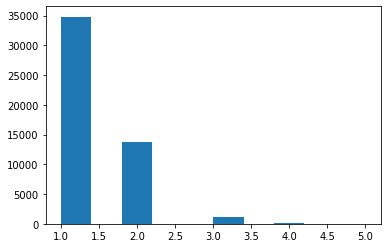

AVProductsEnabled plot:


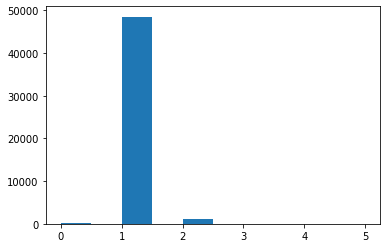

HasTpm plot:


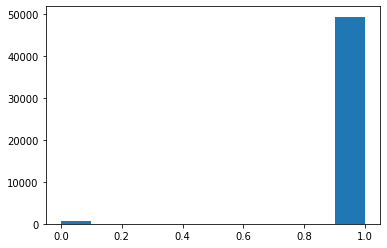

CountryIdentifier plot:


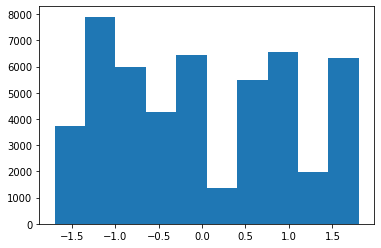

CityIdentifier plot:


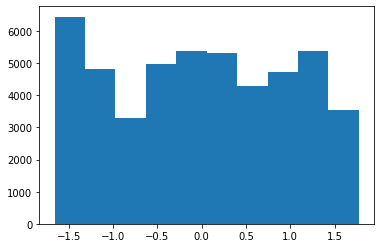

OrganizationIdentifier plot:


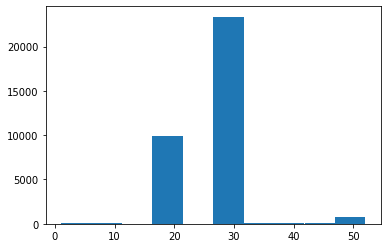

GeoNameIdentifier plot:


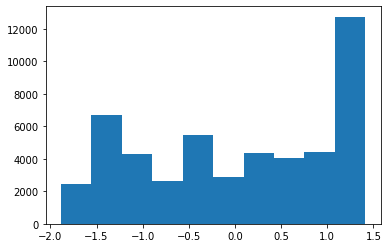

LocaleEnglishNameIdentifier plot:


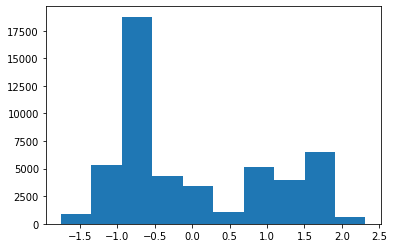

OsBuild plot:


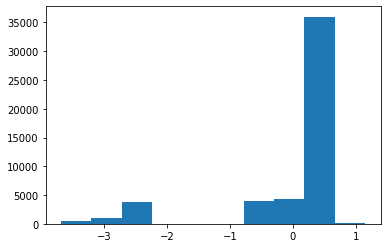

OsSuite plot:


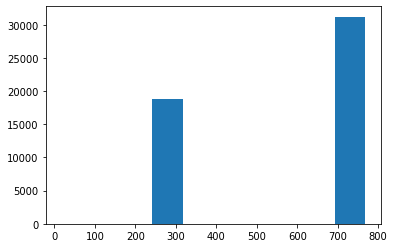

IsProtected plot:


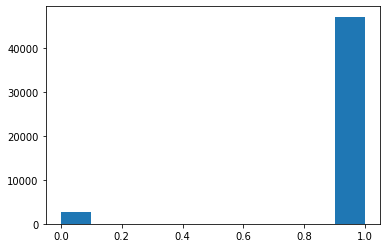

AutoSampleOptIn plot:


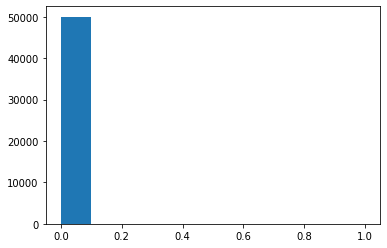

SMode plot:


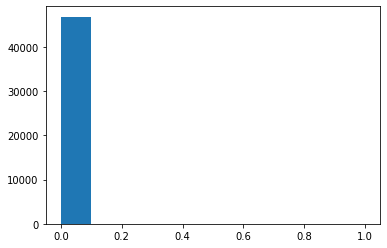

IeVerIdentifier plot:


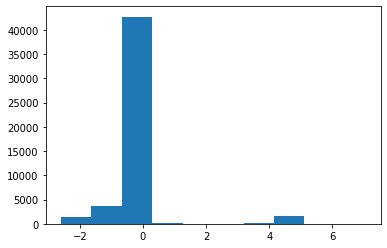

Firewall plot:


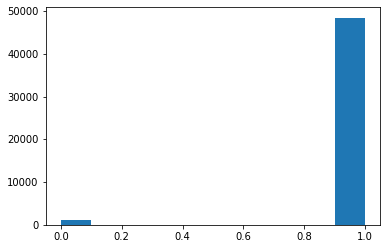

UacLuaenable plot:


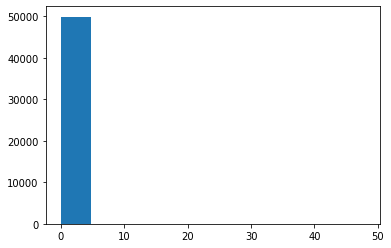

Census_OEMNameIdentifier plot:


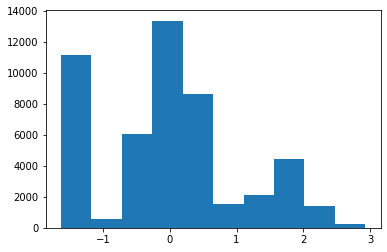

Census_OEMModelIdentifier plot:


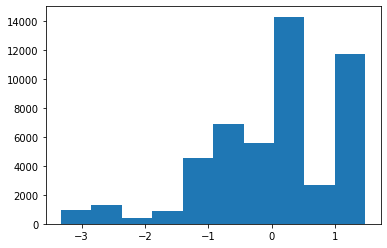

Census_ProcessorCoreCount plot:


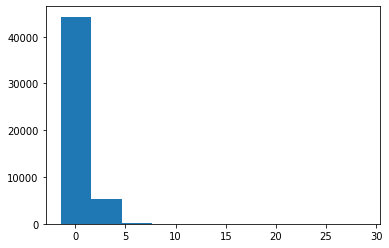

Census_ProcessorManufacturerIdentifier plot:


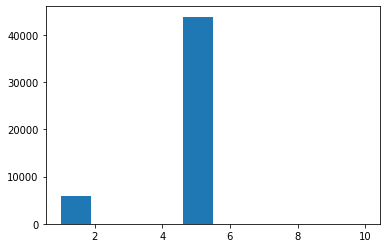

Census_ProcessorModelIdentifier plot:


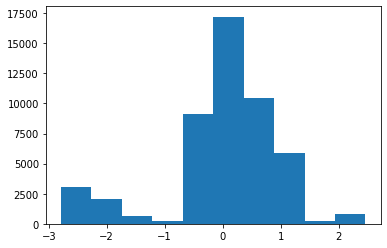

Census_PrimaryDiskTotalCapacity plot:


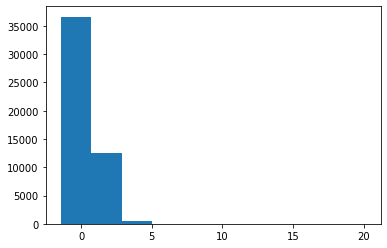

Census_SystemVolumeTotalCapacity plot:


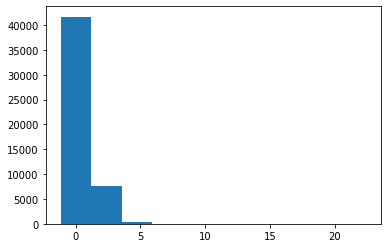

Census_HasOpticalDiskDrive plot:


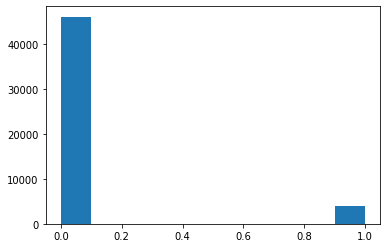

Census_TotalPhysicalRAM plot:


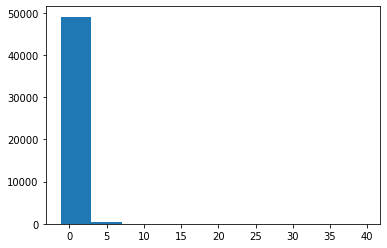

Census_InternalPrimaryDiagonalDisplaySizeInInches plot:


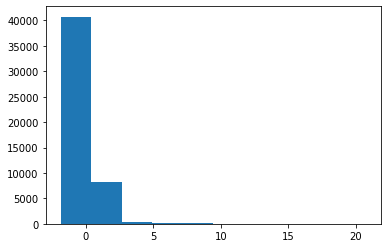

Census_InternalPrimaryDisplayResolutionHorizontal plot:


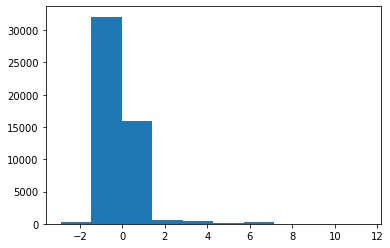

Census_InternalPrimaryDisplayResolutionVertical plot:


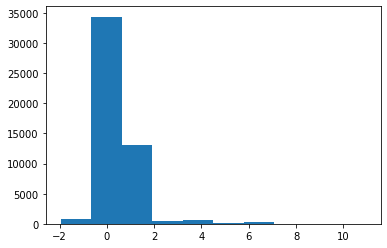

Census_InternalBatteryNumberOfCharges plot:


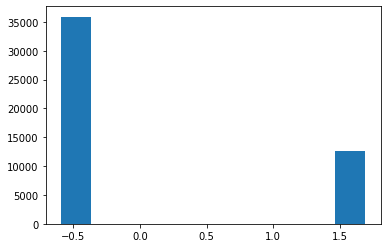

Census_OSBuildNumber plot:


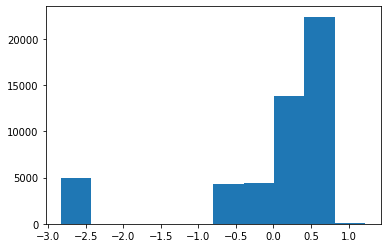

Census_OSBuildRevision plot:


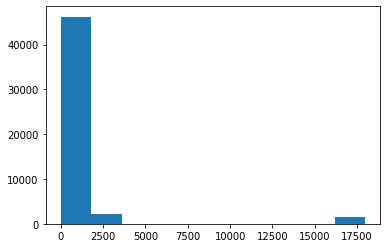

Census_OSInstallLanguageIdentifier plot:


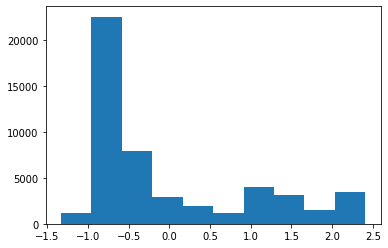

Census_OSUILocaleIdentifier plot:


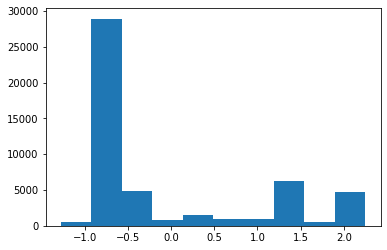

Census_IsPortableOperatingSystem plot:


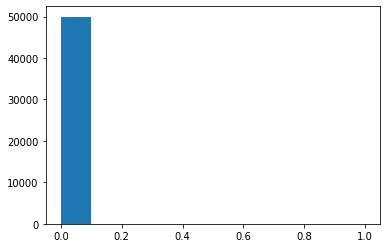

Census_IsFlightingInternal plot:


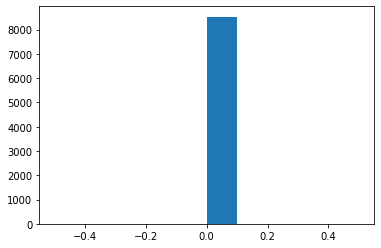

Census_IsFlightsDisabled plot:


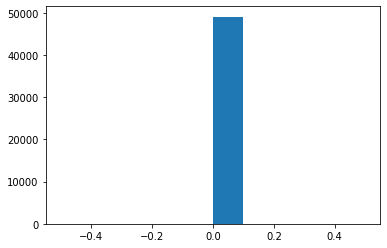

Census_ThresholdOptIn plot:


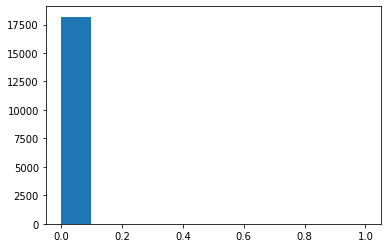

Census_FirmwareManufacturerIdentifier plot:


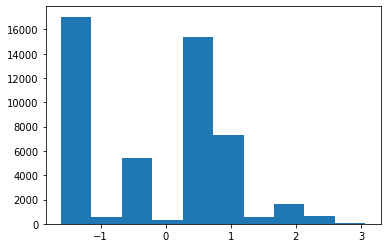

Census_FirmwareVersionIdentifier plot:


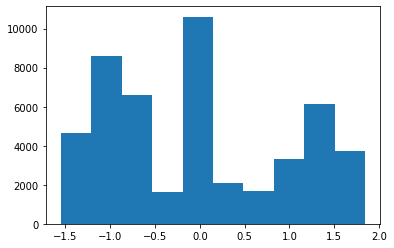

Census_IsSecureBootEnabled plot:


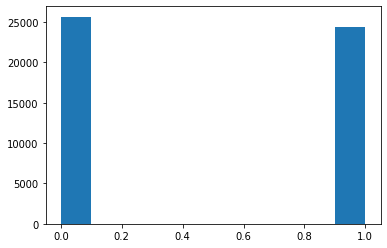

Census_IsWIMBootEnabled plot:


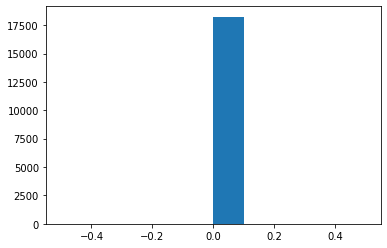

Census_IsVirtualDevice plot:


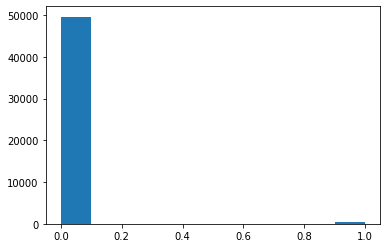

Census_IsTouchEnabled plot:


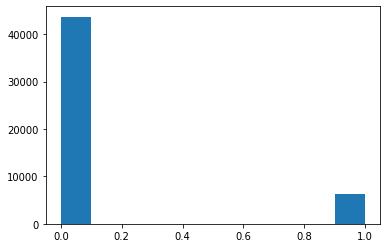

Census_IsPenCapable plot:


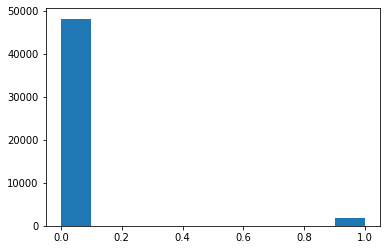

Census_IsAlwaysOnAlwaysConnectedCapable plot:


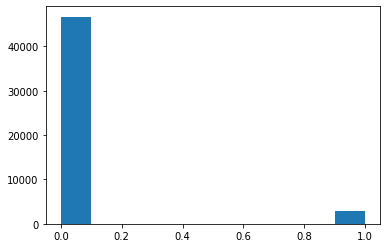

Wdft_IsGamer plot:


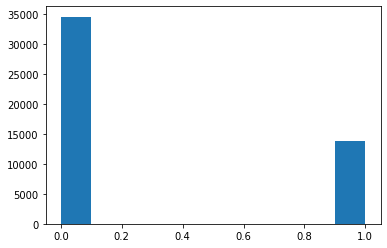

Wdft_RegionIdentifier plot:


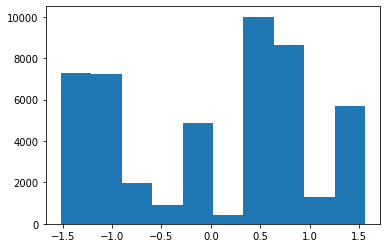

HasDetections plot:


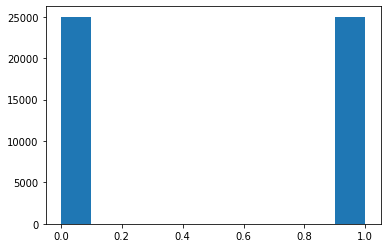

RtpStateBitfield_wasna plot:


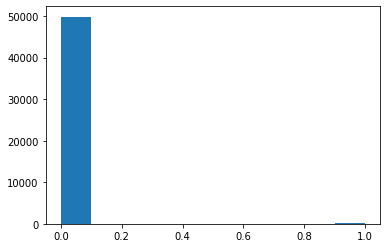

OsBuildLab_wasna plot:


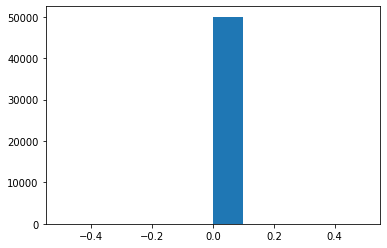

EngineVersion_major plot:


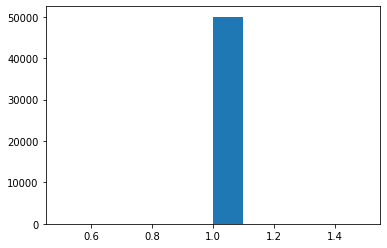

EngineVersion_minor plot:


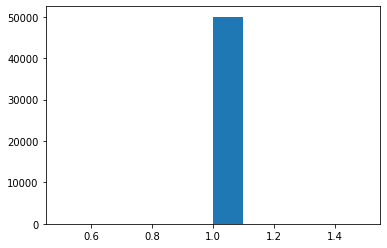

EngineVersion_build1 plot:


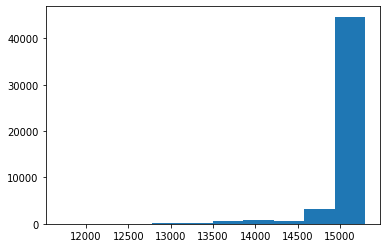

EngineVersion_build2 plot:


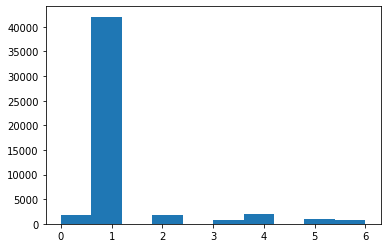

EngineVersion_combined plot:


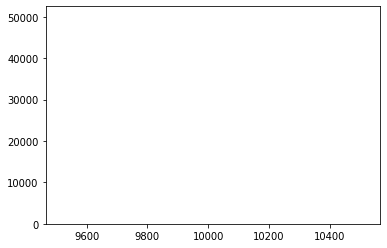

AppVersion_major plot:


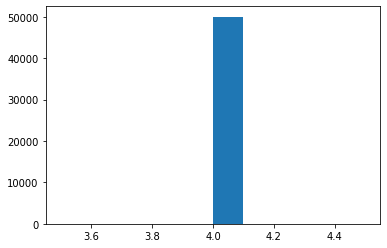

AppVersion_minor plot:


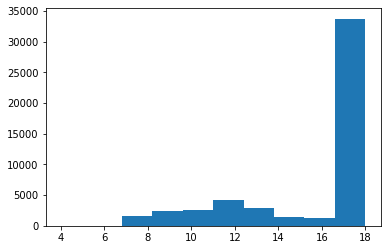

AppVersion_build1 plot:


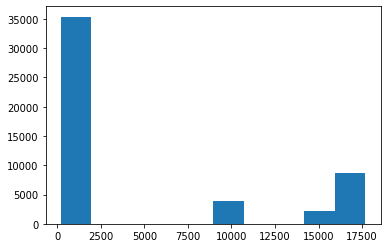

AppVersion_build2 plot:


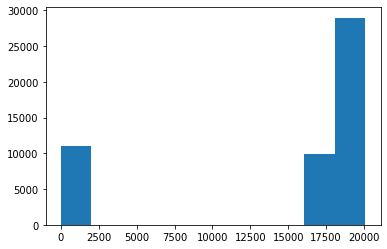

AppVersion_combined plot:


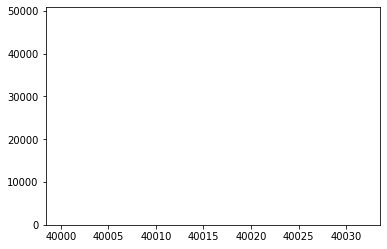

AvSigVersion_major plot:


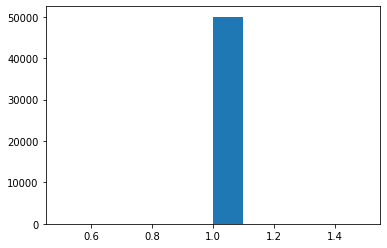

AvSigVersion_minor plot:


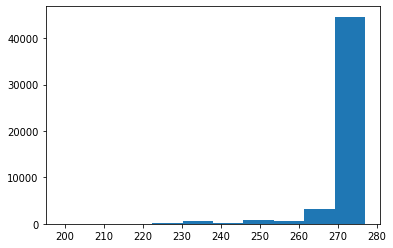

AvSigVersion_build1 plot:


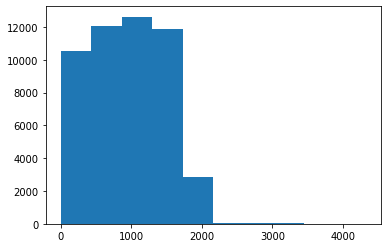

AvSigVersion_build2 plot:


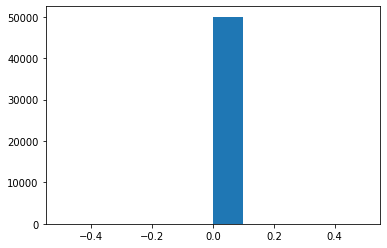

AvSigVersion_combined plot:


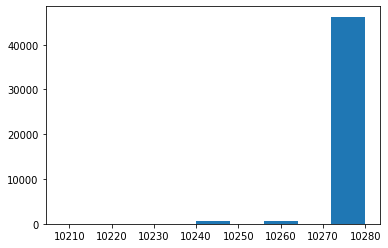

Census_OSVersion_major plot:


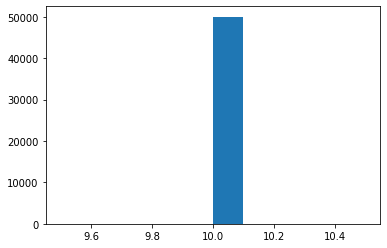

Census_OSVersion_minor plot:


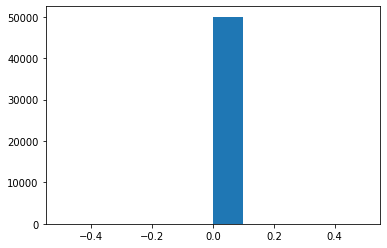

Census_OSVersion_build1 plot:


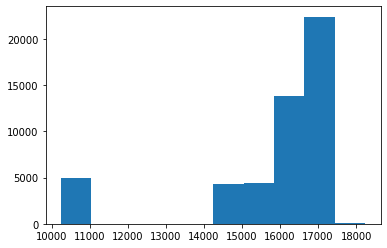

Census_OSVersion_build2 plot:


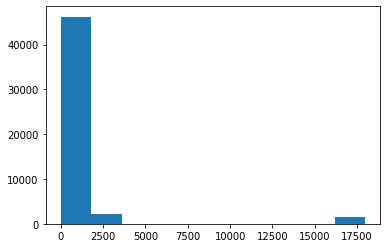

Census_OSVersion_combined plot:


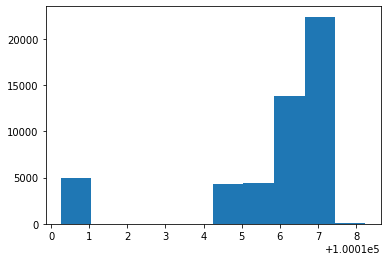

OsVer_major plot:


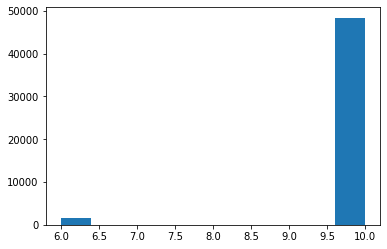

OsVer_minor plot:


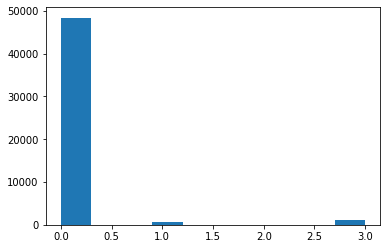

OsVer_build1 plot:


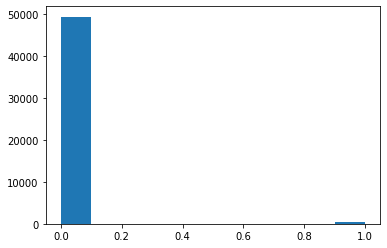

OsVer_build2 plot:


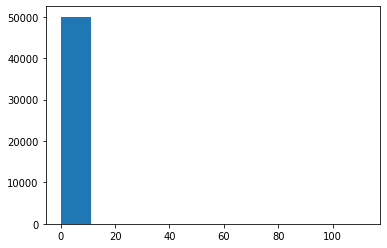

OsVer_combined plot:


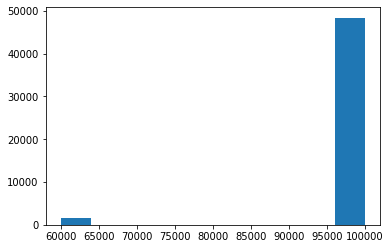

OsBuildLab_major plot:


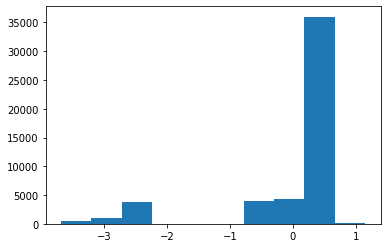

OsBuildLab_minor plot:


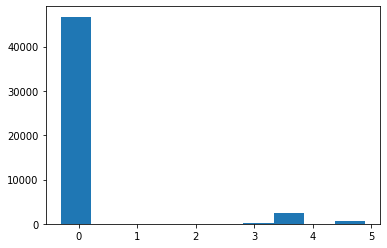

OsBuildLab_build1 plot:


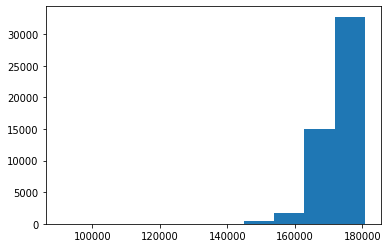

OsBuildLab_build2 plot:


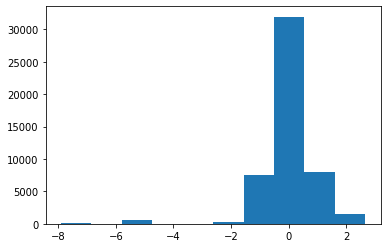

OsBuildLab_combined plot:


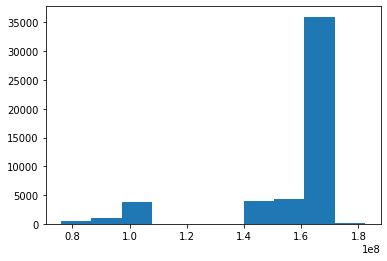

In [25]:
for n in numeric_cols:
    print(n,"plot:")
    plt.hist(train_df[n].dropna())
    plt.show()

In [17]:
print(train_df.shape)
print(df.shape)

#
# encode the values of RtpStateBitfield (NaN, 0, 1, 3, 5, 7, 8, 35) as indicators
#

#df["Rtp_0"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&1 else 0).astype(np.uint8)
#df["Rtp_1"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&2 else 0).astype(np.uint8)
#df["Rtp_2"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&4 else 0).astype(np.uint8)
#df["Rtp_3"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&8 else 0).astype(np.uint8)
#df["Rtp_4"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&16 else 0).astype(np.uint8)
#df["Rtp_5"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&32 else 0).astype(np.uint8)
#df = df.drop(columns=["RtpStateBitfield"])
#print("done encoding RtpStateBitfield")

(50000, 116)
(50000, 116)


In [18]:

x_train = df
#y_train = train_labels


In [19]:
# Testing Cell
#print(x_train.shape)
#print(y_train.shape)

In [20]:
#
# save
#

#train_file = 'data/train_encoded.csv'
train_file = 'data/mini_train_encoded.csv'
#x_train.to_csv(train_file)

df.to_csv(train_file)
